In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torchinfo import summary

#from helper_functions import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 7.0)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def preprocess(dataframe_csvpath, cols_x, cols_y, window_in, window_out, data_div_frac, popu_size):

    """
    Converts the Csv file into required data format for Time Series prediction    
    
    Arguments:
    dataframe_csvpath -- path of csv file, it has the data for different time sceries
    cols_x -- list of columns to be considered as input to the model(Include 'Series_No' as last entry in list)
    cols_y -- list of columns to be outputed by the model(Include 'Series_No' as last entry in list)
    window_in -- the number of time steps as input
    window_out -- the number of time steps to be predicted
    data_div_frac -- the % of data to be divide into test and train sets  
    popu_size -- population size to normalize data
        
        
    Returns:  
    x_train -- the training input data of shape (m, window_in, len(cols_x)); m is number of examples 
    y_train -- the training data labels for input data of shape (m, window_out, len(cols_y)); m is number of examples 
    x_test -- the testing input data of shape (m, window_in, len(cols_x)); m is number of examples  
    y_test -- the testing data labels of shape (m, window_out, cols_y); m is number of examples  
    len_ser -- the total number of days in a series
    win_len_per_ser -- the total number of windows in a series
    
    """
  
    #Loading .CSV file and creating dataframe
    df = pd.read_csv(dataframe_csvpath)   
    len_ser = len(df[df['Series_No'] == 1])

    #randomly shuffle different series
    permute = np.random.permutation(range(1, len(set(df['Series_No']))))
    train_series_seq = permute[: int(len(set(df['Series_No'])) * data_div_frac)]
    test_series_seq = permute[int( len(set(df['Series_No'])) * data_div_frac):]
    
    #taking relevent columns from dataframe  
    df_x = df[cols_x]
    df_y = df[cols_y]
    
    #Innitialize empty lists which are later to be appended
    train_seq, test_seq = [], []
    x_test = []
    y_true =[]
    
    #Creating time series data
    for series_no in train_series_seq:
        
        #new dataframe variable assignment for particular series drom df_x, df_y
        series_df_x = df_x[df_x['Series_No'] == series_no]
        series_df_y = df_x[df_y['Series_No'] == series_no]
        
        #converting into numpy arrays
        array_x = np.array(series_df_x)
        array_y = np.array(series_df_y)
        
        #for loop to append to x_train y_train arrays according to window_in, window_out
        for idx in range(len(series_df_x) - window_in - window_out + 1): #'len(series_df_x) - window_in - window_out + 1' needs to be checked
            arrayx = array_x.copy()
            x = arrayx [idx:idx + window_in, : len(cols_x) - 1]
            #print(x)
            x[:,0:3] = x[:,0:3] / popu_size
            #print(x)
            arrayy = array_y.copy()
            y = arrayy[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1]
            y = y / popu_size
            train_seq.append((x, y)) #out col_x and col_y has last item 'Series number' so to remove that [, : len(cols_x)]
            #y_train.append(array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1])
            #print(train_seq)

    #repeat for test sequence
    for series_no in test_series_seq:
        
        #new dataframe variable assignment for particular series drom df_x, df_y
        series_df_x = df_x[df_x['Series_No'] == series_no]
        series_df_y = df_x[df_y['Series_No'] == series_no]
        
        #converting into numpy arrays
        array_x = np.array(series_df_x)
        array_y = np.array(series_df_y)
        
        #for loop to append to x_train y_train arrays according to window_in, window_out
        for idx in range(len(series_df_x) - window_in - window_out + 1): #'len(series_df_x) - window_in - window_out + 1' needs to be checked
            arrayx = array_x.copy()
            x = arrayx[idx:idx + window_in, : len(cols_x) - 1]
            x[:,0:3] = x[:,0:3] / popu_size
            x_test.append(x)
            arrayy = array_y.copy()
            y = arrayy[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1]
            y = y / popu_size
            y_true.append(y)
            test_seq.append((x, y))
            
            
            #test_seq.append((array_x[idx:idx + window_in, : len(cols_x) - 1], array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1])) #out col_x and col_y has last item 'Series number' so to remove that [, : len(cols_x)]
            #y_test.append(array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1])

    
    win_len_per_ser = len_ser - window_in - window_out + 1
    
    return np.array(train_seq), np.array(test_seq), len_ser, win_len_per_ser, np.array(x_test), np.array(y_true)

In [4]:
window_in = 7
window_out = 1
colsx = ['Cumulative True Cases','Free','Positively Tested','CR', 'Series_No']
colsy = ['Cumulative True Cases','Free','Positively Tested', 'Series_No']
input_shape = (window_in, len(colsx) - 1)
train_seq, test_seq, len_of_ser, num_windows_ser, x_test, y_true = preprocess(dataframe_csvpath = "data.csv", 
    cols_x = colsx, 
    cols_y = colsy, 
    window_in = window_in, 
    window_out = window_out, 
    data_div_frac = 0.99, 
    popu_size = 80000
)

C:\Users\matha\AppData\Local\Temp/ipykernel_5528/1963451887.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(train_seq), np.array(test_seq), len_ser, win_len_per_ser, np.array(x_test), np.array(y_true)


In [7]:
def visualize_data(y_test, x_test, window_out, num_plots, num_win_ser, cols_y, col_idx):
    """
    Visualize a particular column of Y_pred anf Y_test for a particular series
    
    Arguments:
    y_test -- The test y array
    y_pred -- The prediction array
    x_test -- The test x array
    window_out -- len of output window
    num_plots -- Number of plots to show(number of differnt series)
    num_win_ser -- Number of windows in a particular series
    cols_y -- List of stings with column names in y
    col_idx -- Column index to plot


    """
    
    
    ser_idx = [i for i in range(0, len(y_test), num_win_ser)]
    if num_plots > len(ser_idx):
        print("Too many plots, reduce the mumber")
    else:
        indx = ser_idx[0:num_plots]
        days = range(num_win_ser)
        for idx in indx:
            CR = x_test[idx][0][3]
            #pred = y_pred[idx : idx+num_win_ser, window_out -1, col_idx]
            true = y_test[idx : idx+num_win_ser, window_out -1,  col_idx]
            
            plt.title("Y_True, CR: "+ str(CR))
            plt.xlabel('Days')
            plt.ylabel(cols_y[col_idx])
            
            #plt.plot(days, pred, label = 'Pred')
            plt.plot(days, true, label = 'True')
            
            plt.legend()
            plt.show()
    

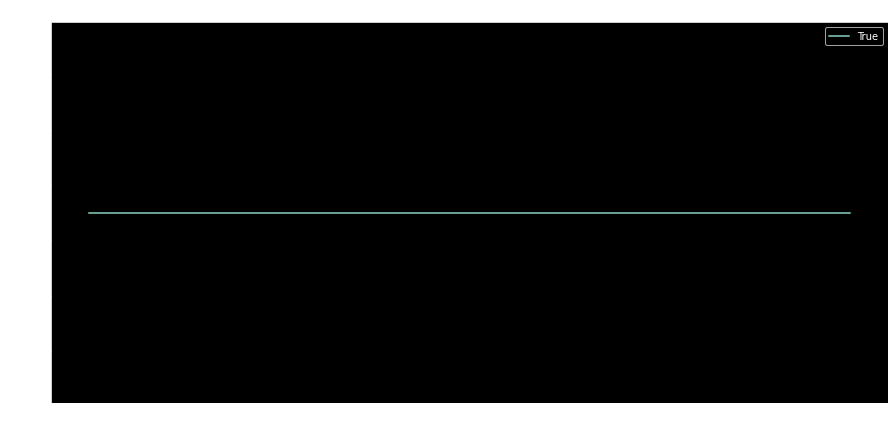

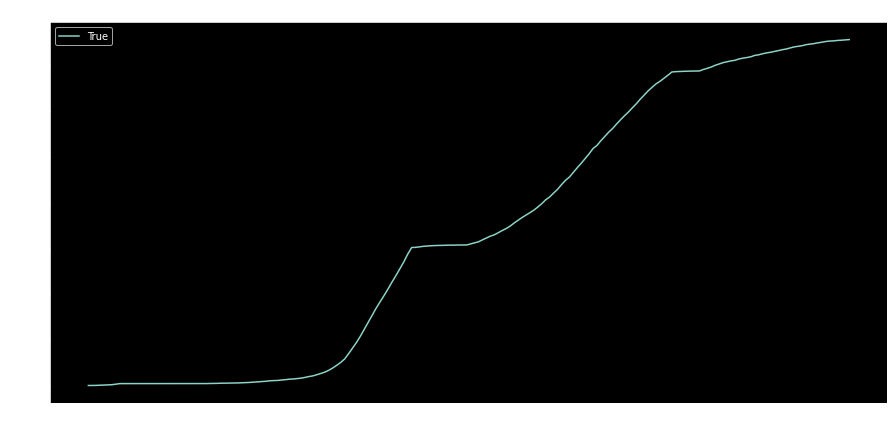

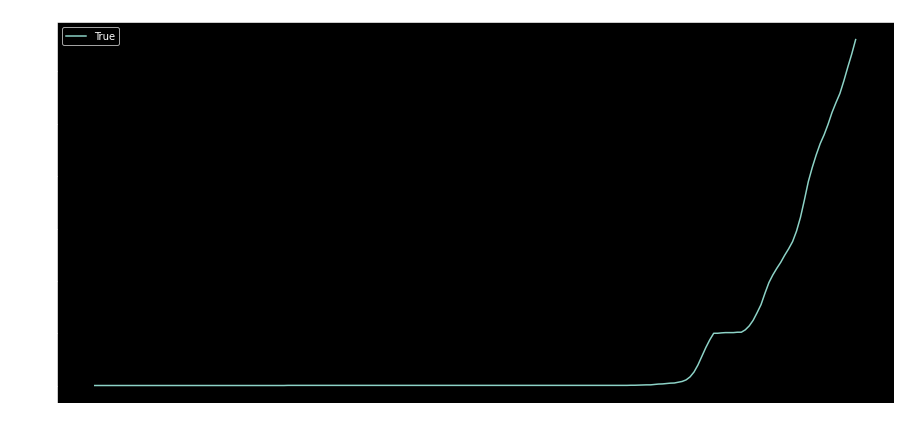

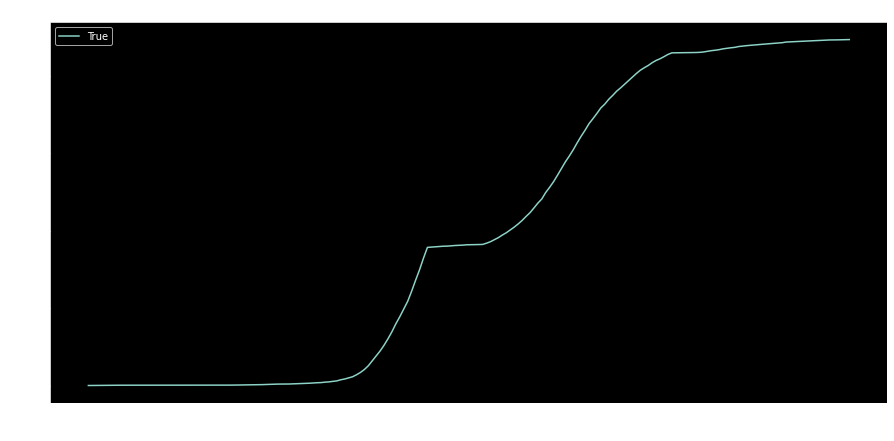

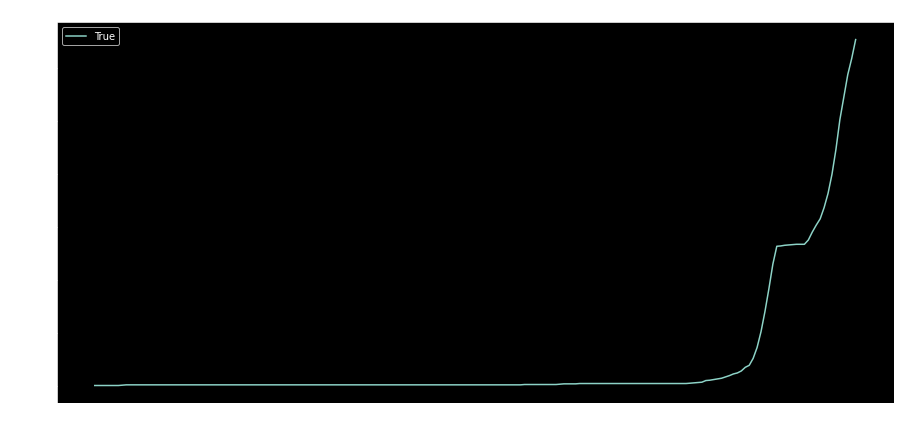

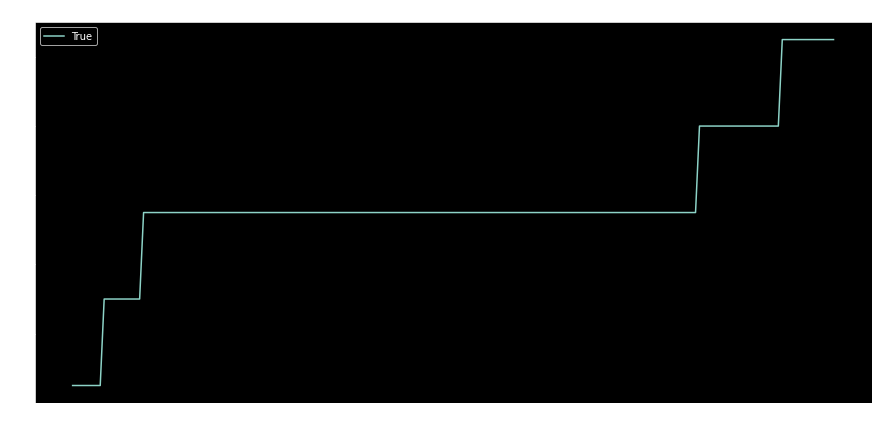

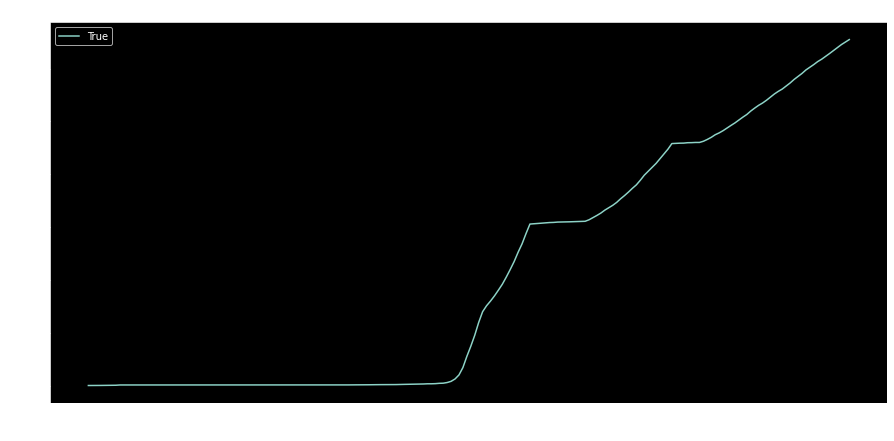

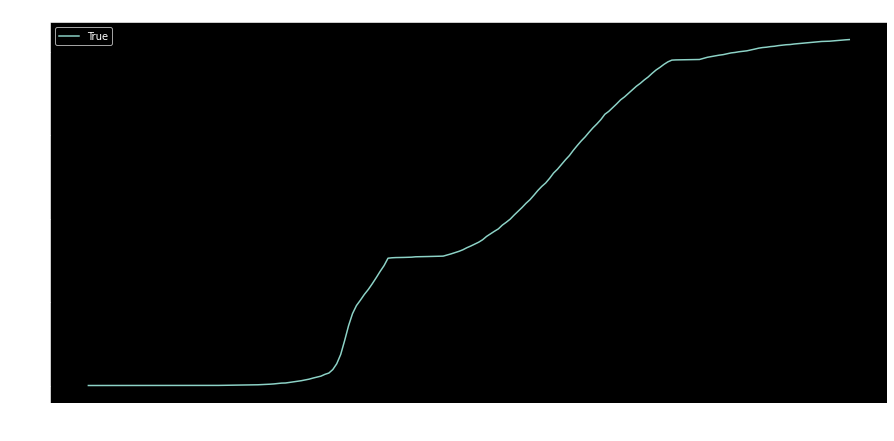

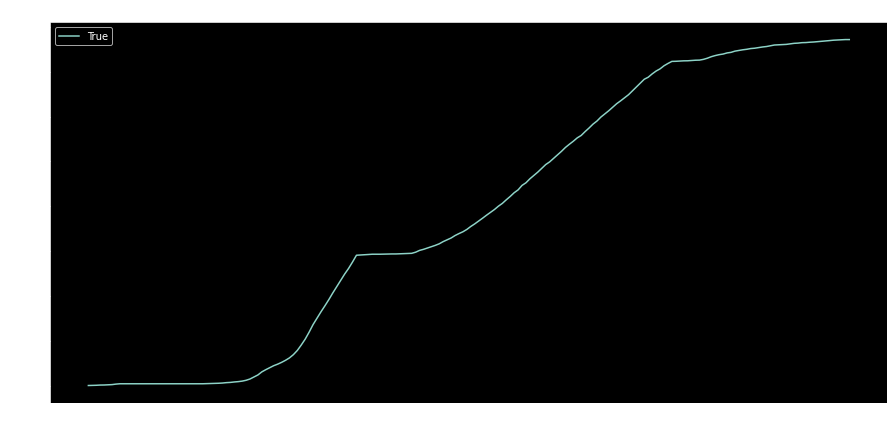

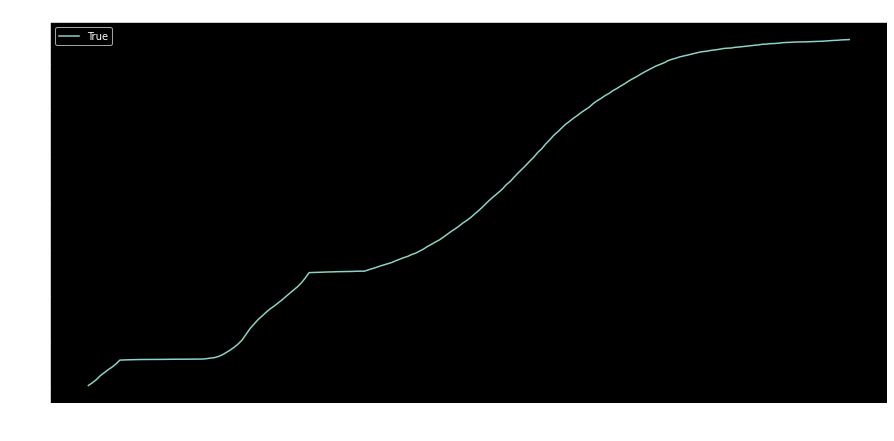

In [8]:
visualize_data(y_test=y_true, x_test=x_test, window_out=window_out, num_plots=10, num_win_ser=num_windows_ser, cols_y=colsy, col_idx=0)

In [7]:
class TSD(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        window, target = self.sequences[idx]
        return torch.tensor(window), torch.tensor(target)

    

In [8]:
train_seq_obj = TSD(train_seq)
test_seq_obj = TSD(test_seq)

In [9]:
class LSTM_TS(nn.Module):
    def __init__(self, nfeat_x, nfeat_y, window_in, window_out):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=nfeat_x, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128*2, hidden_size=256, batch_first=True, num_layers=2 , dropout=0.3, bidirectional =True)
        self.lstm3 = nn.LSTM(input_size= 256 * 2, hidden_size=128, batch_first=True,  bidirectional=True)
        self.fc = nn.Linear(2*128*window_in, nfeat_y * window_out)
        self.yfeat = nfeat_y
        self.xfeat = nfeat_x
        self.win_in = window_in
        self.win_out = window_out
        #self.silu = nn.SiLU()
        self.selu = nn.SELU()
        self.relu = nn.ReLU()


    def forward(self, x):
        x, _ = self.lstm1(x)
        #print('lstm1', x.shape)
        x = self.selu(x)
        x, _ = self.lstm2(x)
        #print('lstm2',x.shape)
        x = self.selu(x)
        x, _ = self.lstm3(x)
        #print('lstm3',x.shape)
        x = self.relu(x)
        x = x.reshape((x.shape[0], -1))
        #print('reshape1',x.shape)
        x = self.fc(x)
        #x = self.silu(x)
        y = x.reshape((x.shape[0], self.win_out, self.yfeat))
        #print('reshapefc1', y.shape)
        
        return y
model = LSTM_TS(nfeat_x=4, nfeat_y=3, window_in=window_in, window_out=window_out).to(device)

summary(model, (1,7,4))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_TS                                  --                        --
├─LSTM: 1-1                              [1, 7, 256]               137,216
├─SELU: 1-2                              [1, 7, 256]               --
├─LSTM: 1-3                              [1, 7, 512]               2,629,632
├─SELU: 1-4                              [1, 7, 512]               --
├─LSTM: 1-5                              [1, 7, 256]               657,408
├─ReLU: 1-6                              [1, 7, 256]               --
├─Linear: 1-7                            [1, 3]                    5,379
Total params: 3,429,635
Trainable params: 3,429,635
Non-trainable params: 0
Total mult-adds (M): 23.98
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 13.72
Estimated Total Size (MB): 13.78

In [10]:
criterion = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [11]:
train_loader = DataLoader(dataset=train_seq_obj, batch_size=num_windows_ser, shuffle=False)
test_loader = DataLoader(dataset=test_seq_obj, batch_size=num_windows_ser, shuffle=False) #always same batch_size

In [12]:
num_epochs = 60
model.train().to(device)
arr_loss = []
for epoch in range(num_epochs):
    
    for idx, (ser, targets) in enumerate(train_loader):
         
        ser = ser.float().to(device)
        targets = targets.float().to(device)
        #print(ser.shape)
        #print(targets.shape)
        pred = model(ser)
        #print(pred[5])
        loss = criterion(pred, targets)
        

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
    arr_loss.append(loss.item())

    print(f'epoch: {epoch + 1}  |  loss: {loss: 5f}')


epoch: 1  |  loss:  0.485560
epoch: 2  |  loss:  0.828798
epoch: 3  |  loss:  0.372770
epoch: 4  |  loss:  1.149619
epoch: 5  |  loss:  0.297375
epoch: 6  |  loss:  0.265410
epoch: 7  |  loss:  0.649307
epoch: 8  |  loss:  0.596590
epoch: 9  |  loss:  0.581951
epoch: 10  |  loss:  0.236936
epoch: 11  |  loss:  0.224522
epoch: 12  |  loss:  0.830822
epoch: 13  |  loss:  0.619610
epoch: 14  |  loss:  0.405928
epoch: 15  |  loss:  0.223959
epoch: 16  |  loss:  0.668017
epoch: 17  |  loss:  0.222049
epoch: 18  |  loss:  0.314799
epoch: 19  |  loss:  0.441027
epoch: 20  |  loss:  0.544445
epoch: 21  |  loss:  0.229095
epoch: 22  |  loss:  0.575320
epoch: 23  |  loss:  0.450512
epoch: 24  |  loss:  0.298218
epoch: 25  |  loss:  0.205403
epoch: 26  |  loss:  0.359836
epoch: 27  |  loss:  0.247027
epoch: 28  |  loss:  0.162299
epoch: 29  |  loss:  0.222698
epoch: 30  |  loss:  0.278816
epoch: 31  |  loss:  0.227839
epoch: 32  |  loss:  0.174389
epoch: 33  |  loss:  0.144813
epoch: 34  |  loss:

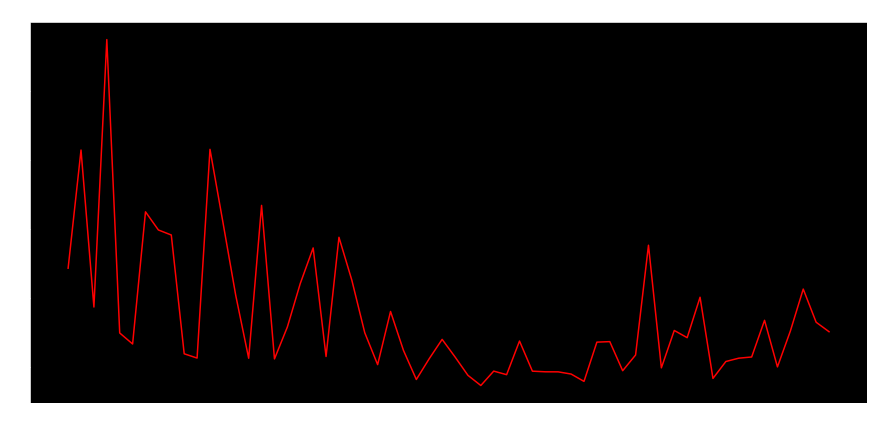

In [13]:
plt.plot(arr_loss, color='red')
plt.title("loss per epoch")
plt.show()

In [16]:
def predictions(loader, model, win_len_per_ser, criterion, window_out = 1):
    """
    Makes Predictions for time series data using the model trained.   
    
    Arguments:
    x_test, y_test -- Testing data
    model -- Model trained previously
    len_seq -- The length of days in a paricular time-series
    window_in -- The input window size for the model
    window_out -- The predicted window size of model
    
    
    Returns:  
    y_pred -- The predicted windows (for plotting)
    mae -- Mean absolute Error of y_pred and y_true
    
    """
  
    model.eval()
    num_win_per_ser = win_len_per_ser   #num windows
    #print(num_win_per_ser)
    y_pred = []
    y_true = []
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):  #for i in range(0, len(y_test), num_win_per_ser): # i takes index values of first windows of different series
            
            win_start = torch.tensor(x[0]).float().to(device) # saving the first window of each series
            #print('win_start:', win_start)
            CR = win_start[0][3] # saving the CR value for particular series -> to be used for prediction
            #print('CR:', CR)
            win = win_start # window variable which will be updated for new windows, takes first value as the starting window
            #print(win)
            win = win.reshape((1, win.shape[0], win.shape[1]))
            #print(win.shape)
            for j in range(num_win_per_ser): # prediction loop 
                y_hat = model(win) # predicting values wrt win variable
                #print('y_hat ', y_hat)  
                y_pred.append(y_hat[0].cpu().detach().numpy()) # add the value to y_pred
                #print('y_pred:', y_pred)
                y_true.append(y[j].cpu().detach().numpy()) # add the value to y_pred
                #print('y_true:', y_true)
                cr_dummy = torch.empty((1, window_out, 1), dtype=torch.float32).to(device)
                y_hat = torch.cat((y_hat, cr_dummy.fill_(float(CR))), 2).float()
                #y_hat = tf.concat([y_hat, tf.fill(dims = (1, window_out, 1), value = CR)], axis = 2) # adding CR value y_hat for furter predictions
                #print('cr added to y_hat', y_hat)   
                win = torch.cat((win, y_hat), 1)
                #win = tf.concat([win, y_hat], axis = 1) # adding our prediction to win
                #print('win', win)
                win = win[:,window_out:,:] # updating win by removing the starting elements
                #print('new_win for next iter', win)

    
        y_pred = torch.tensor(y_pred).to(device)
        y_true = torch.tensor(y_true).to(device)
        assert (y_pred.shape == y_true.shape)

        mae = criterion(y_pred, y_true)
        #mae = tf.reduce_sum(tf.keras.metrics.mean_absolute_error(y_pred, y_test))
        print(f'The error is: " {mae: .5f}')

    model.train()
    return y_pred.cpu().detach().numpy(), y_true.cpu().detach().numpy(), mae.cpu().detach().numpy()



In [17]:
y_pred, y_true, mae = predictions(loader=test_loader, model = model, win_len_per_ser=num_windows_ser, criterion=criterion,window_out=window_out)

C:\Users\matha\AppData\Local\Temp/ipykernel_19652/4081934421.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  win_start = torch.tensor(x[0]).float().to(device) # saving the first window of each series


The error is: "  289.08792


In [9]:
def visualize_data(y_test, x_test, window_out, num_plots, num_win_ser, cols_y, col_idx):
    """
    Visualize a particular column of Y_pred anf Y_test for a particular series
    
    Arguments:
    y_test -- The test y array
    y_pred -- The prediction array
    x_test -- The test x array
    window_out -- len of output window
    num_plots -- Number of plots to show(number of differnt series)
    num_win_ser -- Number of windows in a particular series
    cols_y -- List of stings with column names in y
    col_idx -- Column index to plot


    """
    
    
    ser_idx = [i for i in range(0, len(y_test), num_win_ser)]
    if num_plots > len(ser_idx):
        print("Too many plots, reduce the mumber")
    else:
        indx = ser_idx[0:num_plots]
        days = range(num_win_ser)
        for idx in indx:
            CR = x_test[idx][0][3]
            #pred = y_pred[idx : idx+num_win_ser, window_out -1, col_idx]
            true = y_test[idx : idx+num_win_ser, window_out -1,  col_idx]
            
            plt.title("Y_True, CR: "+ str(CR))
            plt.xlabel('Days')
            plt.ylabel(cols_y[col_idx])
            
            #plt.plot(days, pred, label = 'Pred')
            plt.plot(days, true, label = 'True')
            
            plt.legend()
            plt.show()
    
visualize_data(y_test=y_pred, x_test=x_test, window_out=window_out, num_plots=10, num_win_ser=num_windows_ser, cols_y=colsy, col_idx=0)


NameError: name 'y_pred' is not defined

In [19]:
def visualize(y_test, y_pred, test_seq, window_out, num_plots, num_win_ser, cols_y, col_idx):
    """
    Visualize a particular column of Y_pred anf Y_test for a particular series
    
    Arguments:
    y_test -- The test y array
    y_pred -- The prediction array
    x_test -- The test x array
    window_out -- len of output window
    num_plots -- Number of plots to show(number of differnt series)
    num_win_ser -- Number of windows in a particular series
    cols_y -- List of stings with column names in y
    col_idx -- Column index to plot


    """
    
    
    ser_idx = [i for i in range(0, len(y_test), num_win_ser)]
    if num_plots > len(ser_idx):
        print("Too many plots, reduce the mumber")
    else:
        indx = ser_idx[0:num_plots]
        days = range(num_win_ser)
        for idx in indx:
            CR = test_seq[idx][0][0][3]
            pred = y_pred[idx : idx+num_win_ser, window_out -1, col_idx]
            true = y_test[idx : idx+num_win_ser, window_out -1,  col_idx]
            
            plt.title("Y_True V/S Y_Pred, CR: "+ str(CR))
            plt.xlabel('Days')
            plt.ylabel(cols_y[col_idx])
            
            plt.plot(days, pred, label = 'Pred')
            plt.plot(days, true, label = 'True')
            
            plt.legend()
            plt.show()


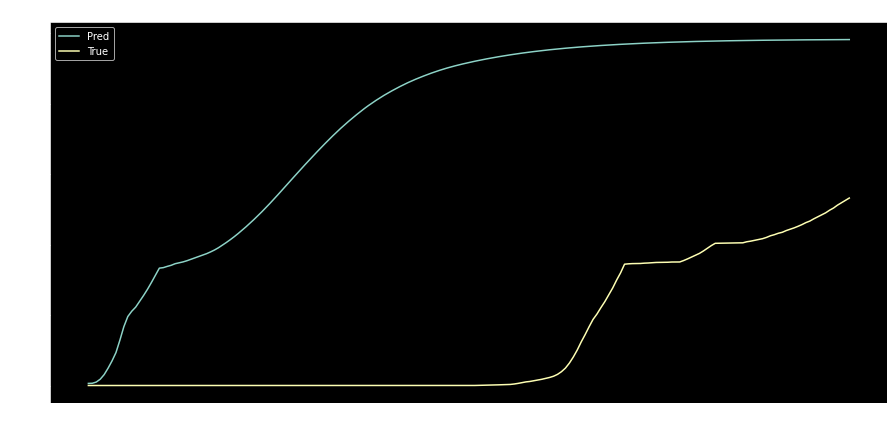

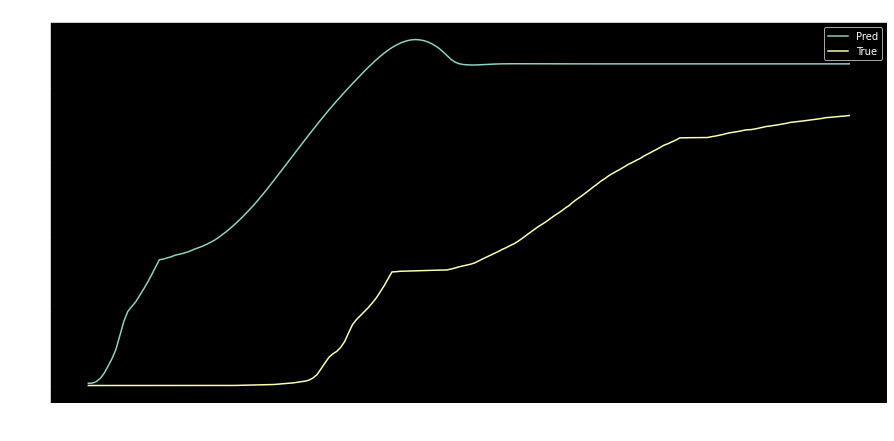

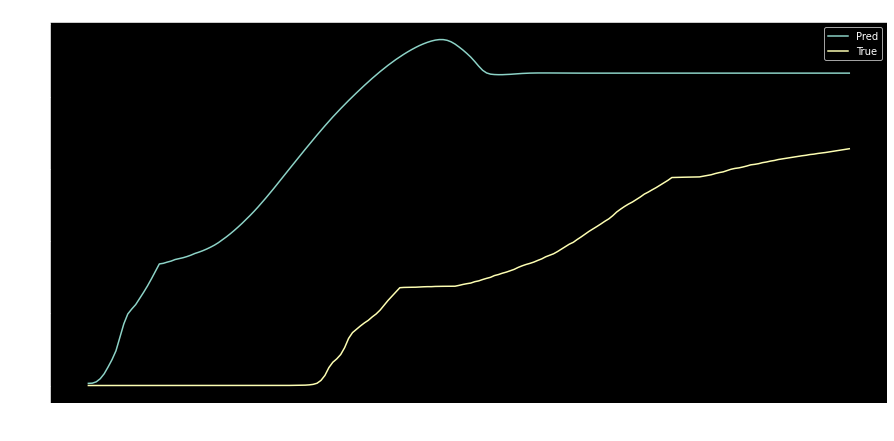

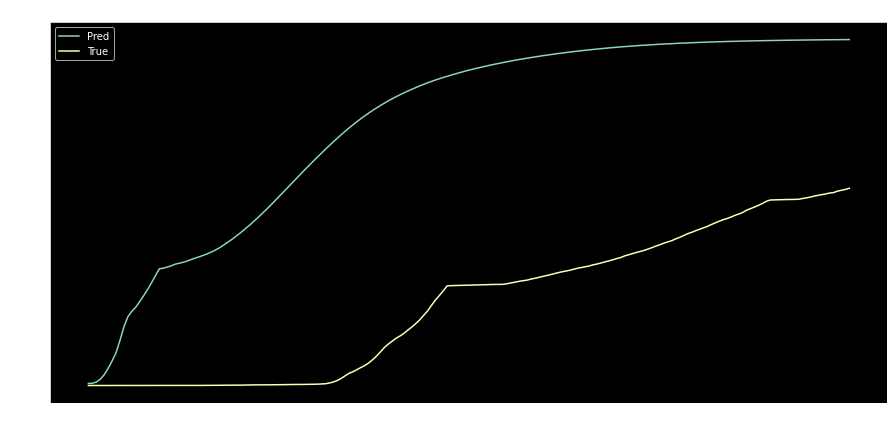

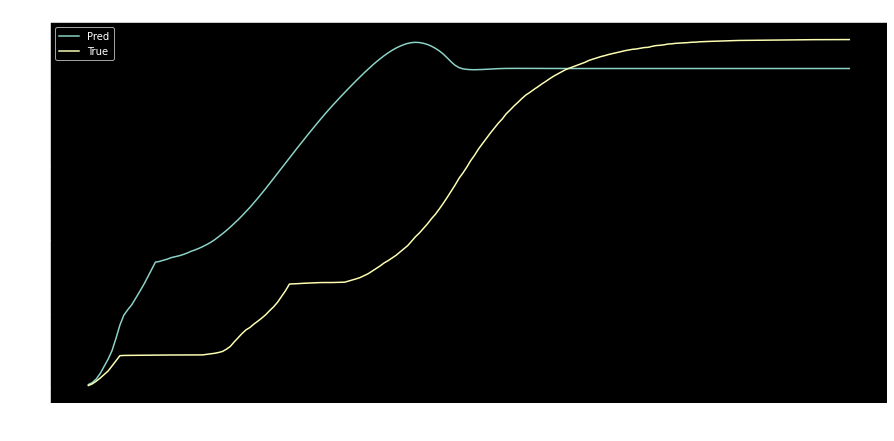

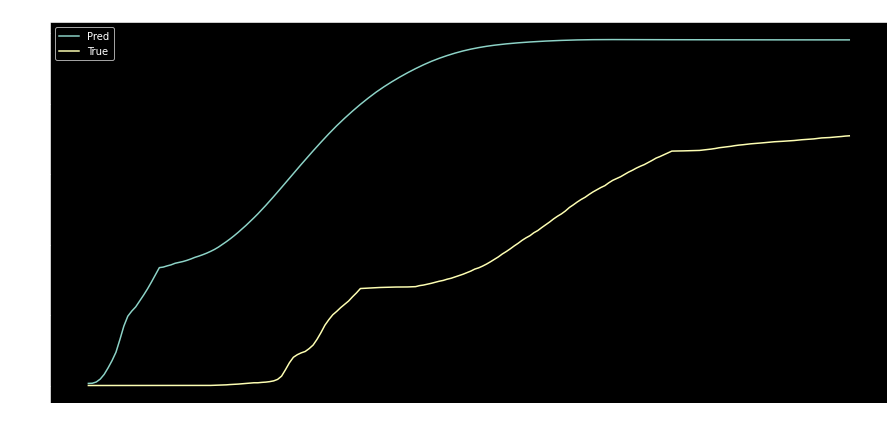

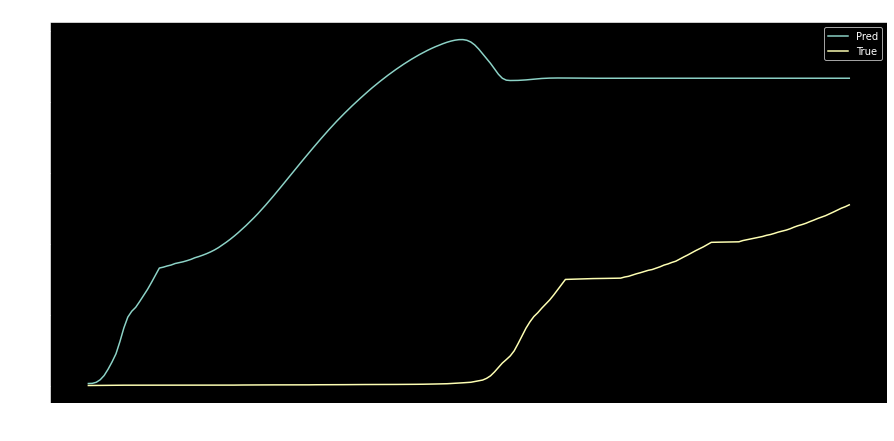

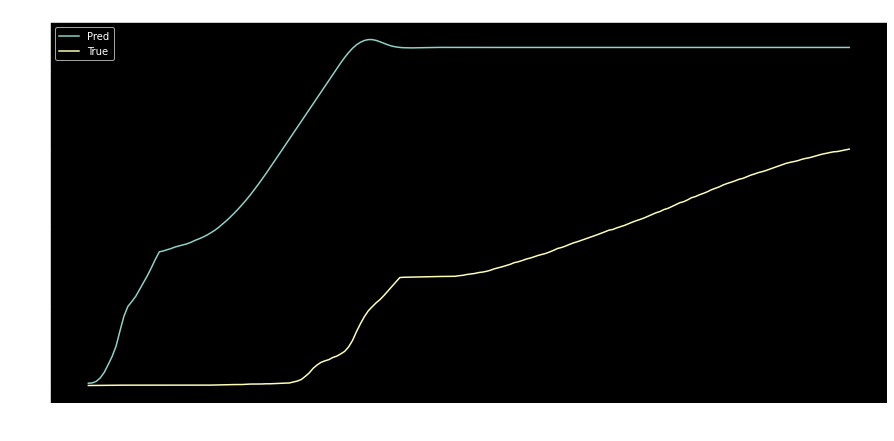

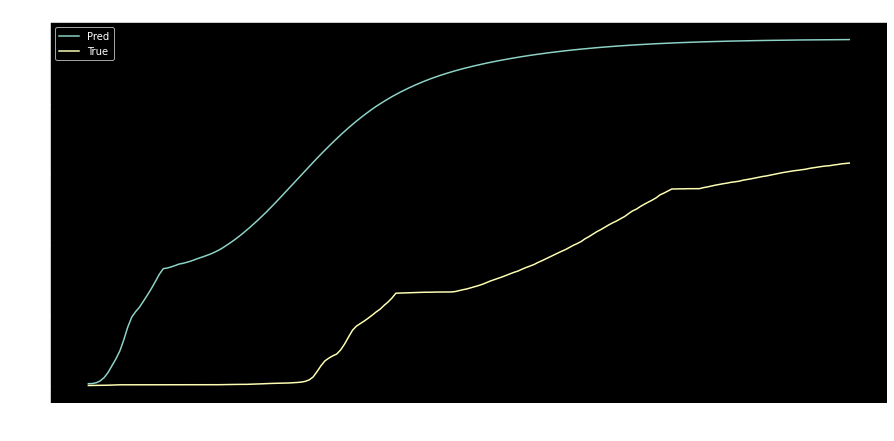

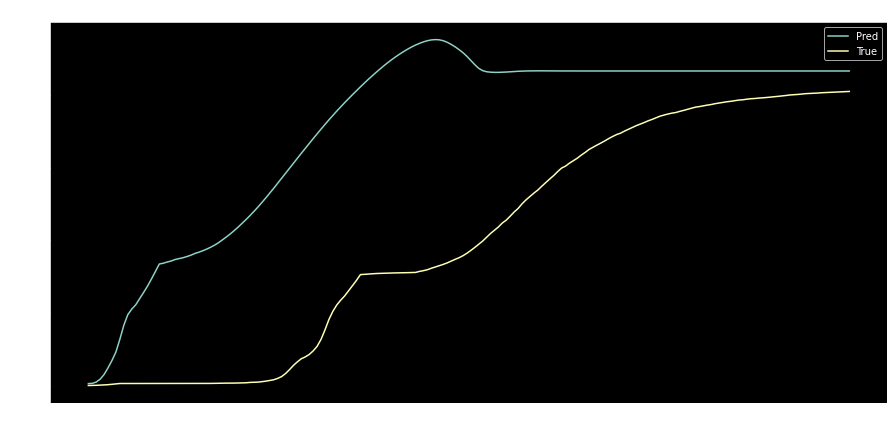

In [20]:
visualize(y_test=y_true, y_pred=y_pred, test_seq=test_seq, window_out=window_out, num_plots=10, num_win_ser=num_windows_ser, cols_y=colsy, col_idx=0)